In [11]:
pip install imbalanced-learn xgboost


In [28]:
import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [ ]:
from google.colab import files
files.upload()


In [14]:
data=pd.read_csv("Creditcard_data.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
print("original class distribution")
print(data['Class'].value_counts())

original class distribution
Class
0    763
1      9
Name: count, dtype: int64


In [16]:
x=data.drop('Class',axis=1)
y=data['Class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state=42, stratify=y )

In [18]:
#Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("Random Under-Sampling:", Counter(y_rus))


#Random Over-Sampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print("Random Over-Sampling:", Counter(y_ros))

#SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("SMOTE:", Counter(y_smote))

#NearMiss
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_train, y_train)

print("NearMiss:", Counter(y_nm))

#Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)

print("Tomek Links:", Counter(y_tl))

Random Under-Sampling: Counter({0: 6, 1: 6})
Random Over-Sampling: Counter({0: 534, 1: 534})
SMOTE: Counter({0: 534, 1: 534})
NearMiss: Counter({0: 6, 1: 6})
Tomek Links: Counter({0: 531, 1: 6})


In [22]:
def get_accuracy(model, Xtr, ytr):
    model.fit(Xtr, ytr)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [32]:
models = {
    "M1_LogReg": LogisticRegression(max_iter=5000),
    "M2_DT": DecisionTreeClassifier(random_state=42),
    "M3_RF": RandomForestClassifier(random_state=42),
    "M4_SVM": SVC(),
    "M5_KNN": KNeighborsClassifier()
}


In [33]:
samples = {
    "Sampling1": (X_rus, y_rus),
    "Sampling2": (X_ros, y_ros),
    "Sampling3": (X_smote, y_smote),
    "Sampling4": (X_nm, y_nm),
    "Sampling5": (X_tl, y_tl)
}


In [34]:
results = pd.DataFrame(index=models.keys(), columns=samples.keys())

for m_name, model in models.items():
    for s_name, (Xs, ys) in samples.items():
        acc = get_accuracy(model, Xs, ys)
        results.loc[m_name, s_name] = round(acc * 100, 2)

results


,Sampling1,Sampling2,Sampling3,Sampling4,Sampling5
M1_LogReg,57.76,91.81,93.53,18.53,98.71
M2_DT,38.79,96.98,98.71,15.95,98.28
M3_RF,66.81,99.14,98.71,50.86,98.71
M4_SVM,74.57,87.5,43.53,38.79,98.71
M5_KNN,75.0,97.84,72.41,39.66,98.71


In [26]:
results.idxmax(axis=1)


,0
M1_LogReg,Sampling5
M2_DT,Sampling3
M3_RF,Sampling2
M4_SVM,Sampling5
M5_KNN,Sampling5


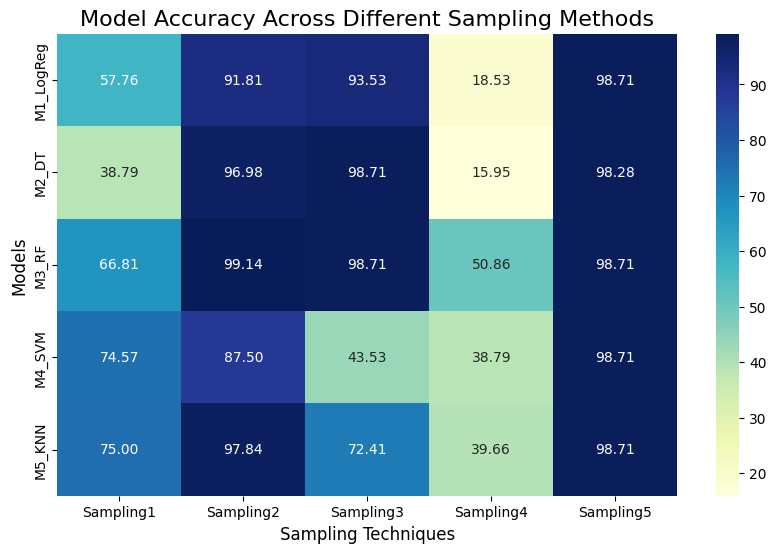

In [31]:
results_float = results.astype(float)
plt.figure(figsize=(10,6))
sns.heatmap(results_float, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Model Accuracy Across Different Sampling Methods", fontsize=16)
plt.xlabel("Sampling Techniques", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.show()